In [27]:
install.packages("baseballr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [28]:
install.packages("dplyr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [47]:
install.packages("StanHeaders", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))
install.packages("rstan", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘abind’, ‘tensorA’, ‘distributional’, ‘checkmate’, ‘matrixStats’, ‘posterior’, ‘inline’, ‘gridExtra’, ‘loo’, ‘QuickJSR’, ‘BH’




In [50]:
install.packages("posterior")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [52]:
install.packages("bayesplot")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘ggridges’, ‘reshape2’




In [53]:
.libPaths('usr/local/lib/R/site-library/')
# library(tidyverse)
library(rstan)
rstan_options(auto_write = TRUE)  # save compiled STAN object
# library(shinystan)  # graphical exploration
library(posterior)  # for summarizing draws
library(bayesplot)  # for plotting
theme_set(theme_classic() +
    theme(panel.grid.major.y = element_line(color = "grey92")))

This is bayesplot version 1.14.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching package: ‘bayesplot’


The following object is masked from ‘package:posterior’:

    rhat




I decided to choose a new dataset but with a similar one parameter model to what I did in the last homework. For my final project, I would like to model the MLB draft.
# 0) Defining Reaching MLB Within Seven Years

For each drafted player $i$ we observe:
The draft year $d_i \in \{2015, 2016, 2017, 2018\}$.

The player's MLB debut date $T_i$, if any; otherwise $T_i$ is missing.

Define a player as having ``reached MLB within seven years'' if they debut on or before the end of the calendar year that is seven years after their draft year. Formally, we define a player-specific cutoff date
$C_i = December 31 of year (d_i + 7)$,

and an indicator
  $R_i =
  \begin{cases}
    1, & \text{if $T_i$ is observed and } T_i \le C_i, \\
    0, & \text{otherwise.}
  \end{cases}
$

Thus, $R_i = 1$ if player $i$ debuts in MLB within seven years of being drafted, and $R_i = 0$ if they have not debuted by the end of that seven-year window (including players who never debut).

The dataset I scraped includes draft classes from 2015--2018, and I observe debut dates through the end of the 2025 season, so that the full seven-year window is observable for all four draft cohorts. The draft consisted of 40 rounds in each of the years I study, so the overall composition of the drafted player pool is broadly comparable across cohorts. This makes it reasonable to model a single aggregate probability of reaching MLB over all rounds for 2015–2017. By contrast, nder the current 20-round draft, we would expect a higher overall probability of reaching MLB among draftees, simply because teams are no longer selecting the many very-low-probability players who used to be taken in rounds 21–40.

\begin{aligned}
  &\text{2015 draftees: } C_i = \text{Dec 31, 2022}, \\
  &\text{2016 draftees: } C_i = \text{Dec 31, 2023}, \\
  &\text{2017 draftees: } C_i = \text{Dec 31, 2024}, \\
  &\text{2018 draftees: } C_i = \text{Dec 31, 2025}.
\end{aligned}


In [54]:
library(baseballr)

df15 <- mlb_draft(year = 2015)
df16 <- mlb_draft(year = 2016)
df17 <- mlb_draft(year = 2017)
df18 <- mlb_draft(year = 2018)

draft <- dplyr::bind_rows(df15, df16, df17, df18)
write.csv(draft, "bref_draft_2015_2018.csv", row.names = FALSE)


In [82]:
library(dplyr)
library(lubridate)

draft_model <- draft_war %>%
  mutate(
    draft_year = as.integer(year),
    person_mlb_debut_date = ymd(person_mlb_debut_date),

    # 7-year cutoff: end of (draft_year + 7)
    cutoff_date = ymd(paste0(draft_year + 7, "-12-31")),

    # Indicator: debuted within 7 years of draft
    reached_mlb_7yr = !is.na(person_mlb_debut_date) &
                      person_mlb_debut_date <= cutoff_date
  )

# glimpse(draft_model)


# 1) One-Parameter Beta--Binomial Model
Let $p$ denote the probability that a drafted player reaches MLB within seven years, as defined above. I first restrict attention to the 2015-2017 draft classes and treat them as exchangeable with a common success probability $p$.

For the 2015--2017 drafts, let
$n_{\text{train}} = \text{number of drafted players in 2015--2017}, \qquad
  Y_{\text{train}} = \sum_{i \in \text{2015--2017}} R_i$
be the number of players and the number who reached MLB within seven years, respectively.

The likelihood for $Y_{\text{train}}$ given $p$ is
$
  Y_{\text{train}} \mid p \sim \mathrm{Binomial}\bigl(n_{\text{train}}, p\bigr).
$

I place a Beta prior on $p$,

$p \sim \mathrm{Beta}(a, b)$,

I choose a weakly informative prior for $p$, rather than constructing a strong prior from earlier draft classes. Draft strategies and player development practices have changed over time, so I don't expect data from much older eras to be directly comparable to recent drafts. Using historical data as a prior would assume that the pre-2015 environment is informative about current outcomes, which I view as unrealistic. Instead, I place a $\mathrm{Beta}(1,1)$ prior on $p$, which is uniform on $[0,1]$ and expresses only that all values between 0 and 1 are a priori possible. This allows the observed outcomes for the 2015--2017 draft classes to dominate the posterior while avoiding strong assumptions based on older draft cohorts.

By conjugacy, the posterior distribution of $p$ given the training data is also Beta:
$ p \mid Y_{\text{train}} \sim \mathrm{Beta}\bigl(a^\ast, b^\ast\bigr),
  \qquad
  a^\ast = a + Y_{\text{train}}, \quad
  b^\ast = b + n_{\text{train}} - Y_{\text{train}}.
$
# 2) Posterior Predictive Check Using the 2018 Draft Class
To assess model fit and predictive performance, I treat the 2018 draft class as a held-out cohort. Let
$n_{\text{test}} = \text{number of players drafted in 2018}, \qquad$
$  Y_{\text{test}} = \sum_{i \in \text{2018}} R_i$
denote the number of 2018 draftees and the number of those players who reached MLB within seven years.

Under the model, the posterior predictive distribution for the number of 2018 draftees who reach MLB within seven years is
$
  \tilde{Y}_{2018} \mid Y_{\text{train}}
  \sim \mathrm{Beta\mbox{-}Binomial}\bigl(n_{\text{test}}, a^\ast, b^\ast\bigr),
$
which can be generated by first drawing $p \sim \mathrm{Beta}(a^\ast, b^\ast)$ and then
$
  \tilde{Y}_{2018} \mid p \sim \mathrm{Binomial}(n_{\text{test}}, p).
$
I use this posterior predictive distribution for $\tilde{Y}_{2018}$ to perform a posterior predictive check by comparing the observed value $Y_{\text{test}}$ to the simulated values.


In [56]:
# Split train and test:
train <- draft_model %>%
  filter(year %in% 2015:2017)

test <- draft_model %>%
  filter(year == 2018)


In [57]:
# Calculate n and y
n_train <- nrow(train)
Y_train <- sum(train$reached_mlb_7yr)

n_train
Y_train


[1] 3645

[1] 662

In [58]:
# Calculate n and y test
n_test <- nrow(test)
Y_test <- sum(test$reached_mlb_7yr)

n_test
Y_test


[1] 1214

[1] 218

In [83]:
# Calculate model in R
set.seed(321)

a <- 1
b <- 1

a_post <- a + Y_train
b_post <- b + n_train - Y_train

# Draw from posterior
n_sims <- 4000
p_beta <- rbeta(n_sims, a_post, b_post)

# Training PPC
Y_rep_tr_beta <- rbinom(n_sims, n_train, p_beta)

# Test PPC (for 2018)
Y_rep_te_beta <- rbinom(n_sims, n_test, p_beta)


# analytic posterior summaries
beta_mean <- a_post / (a_post + b_post)
beta_sd   <- sqrt(a_post * b_post / ((a_post + b_post)^2 * (a_post + b_post + 1)))
beta_ci   <- qbeta(c(0.025, 0.975), a_post, b_post)

beta_mean
beta_sd
beta_ci



[1] 0.1817933

[1] 0.006385472

[1] 0.1694448 0.1944723

Draw many values of 𝑝 p from the posterior Beta(𝑎\*,𝑏\*) using the 2015–2017 data.

For each draw, simulate a fake training dataset:$𝑌_
{train}∼Binomial(𝑛_{train},𝑝)$
$Y_{train}∼Binomial(n_{train},p)$

Compare with actual y_train red line

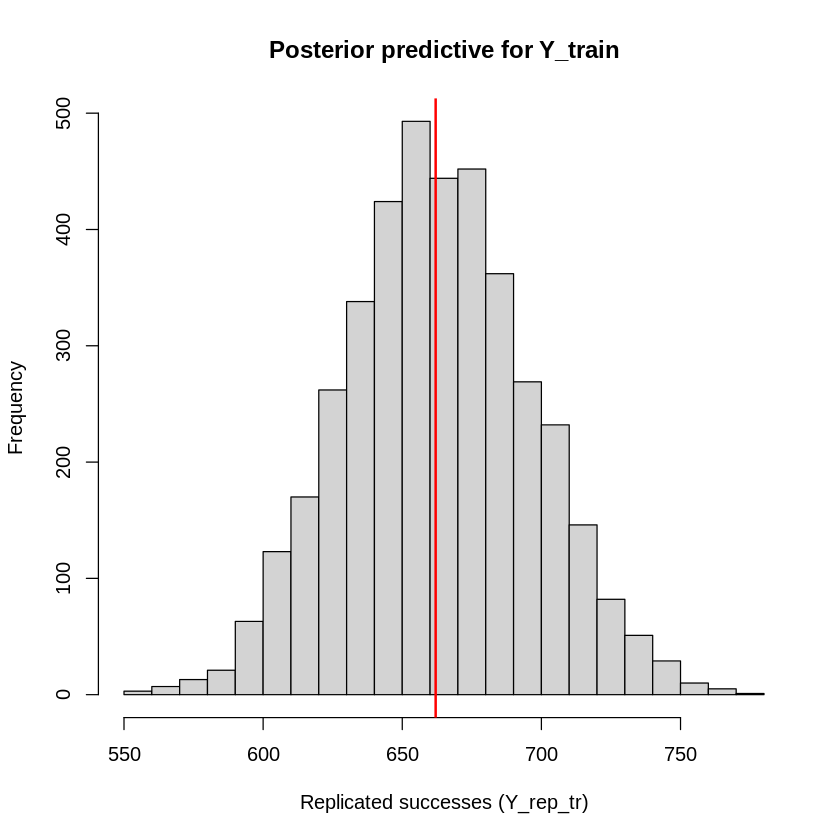

In [84]:

hist(
  Y_rep_tr,
  breaks = 30,
  main = "Posterior predictive for Y_train",
  xlab  = "Replicated successes (Y_rep_tr)"
)
abline(v = Y_train, col = "red", lwd = 2)


Fit looks okay. Now, simulate a fake 2018 class and compare with observed 2018:

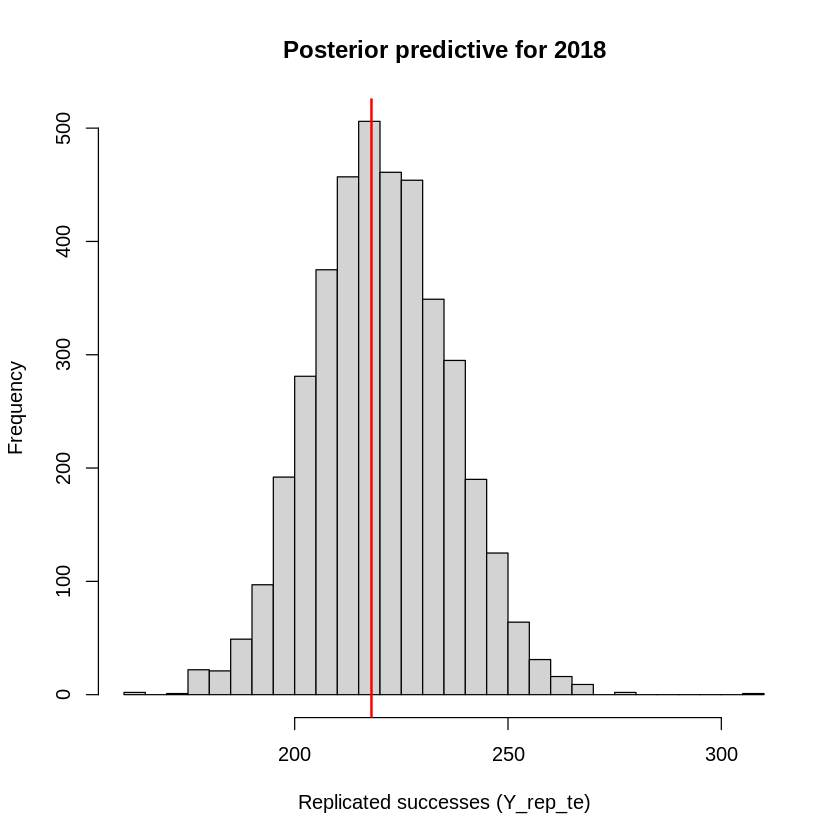

In [85]:
# Does model replicate 2018 well?
# Yes, fit looks pretty close.

hist(
  Y_rep_te,
  breaks = 30,
  main = "Posterior predictive for 2018",
  xlab  = "Replicated successes (Y_rep_te)"
)
abline(v = Y_test, col = "red", lwd = 2)


#Exercise 3.1 Use MCMC in STAN to fit model

I fit the model in STAN using 3 chains and 5,000 iterations with 2,500 for warmups. Rhat around 1 shows good agreement between chains, and MCMC does look to converge for this model, with no visible trends and the chains exploring the same region. Effective sample size of around 3,600 out of 10,000 post warmup is sufficient.

In [89]:
# now use MCMC in Stan
library(rstan)

stan_data <- list(N = n_train, Y = Y_train, a = 1, b = 1)

fit_mcmc <- stan(
  file = "reachMLB7.stan",
  data = stan_data,
  seed = 321,
  iter = 5000,
  chains = 4,
  control = list(adapt_delta = 0.85)
)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 7e-06 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Warmup)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Warmup)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Warmup)
Chain 1: Iteration: 2501 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Sampling)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Sampling)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.021 seconds (Warm-up)
Chain 1:                0.022 seconds (Sampling)
Chain 1:                0.043 

Inference for Stan model: anon_model.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

     mean se_mean      sd    2.5%    25%     50%     75%   97.5% n_eff    Rhat
p 0.18196   1e-04 0.00625 0.16996 0.1777 0.18196 0.18622 0.19428  3647 1.00041

Samples were drawn using NUTS(diag_e) at Wed Nov 26 23:18:38 2025.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


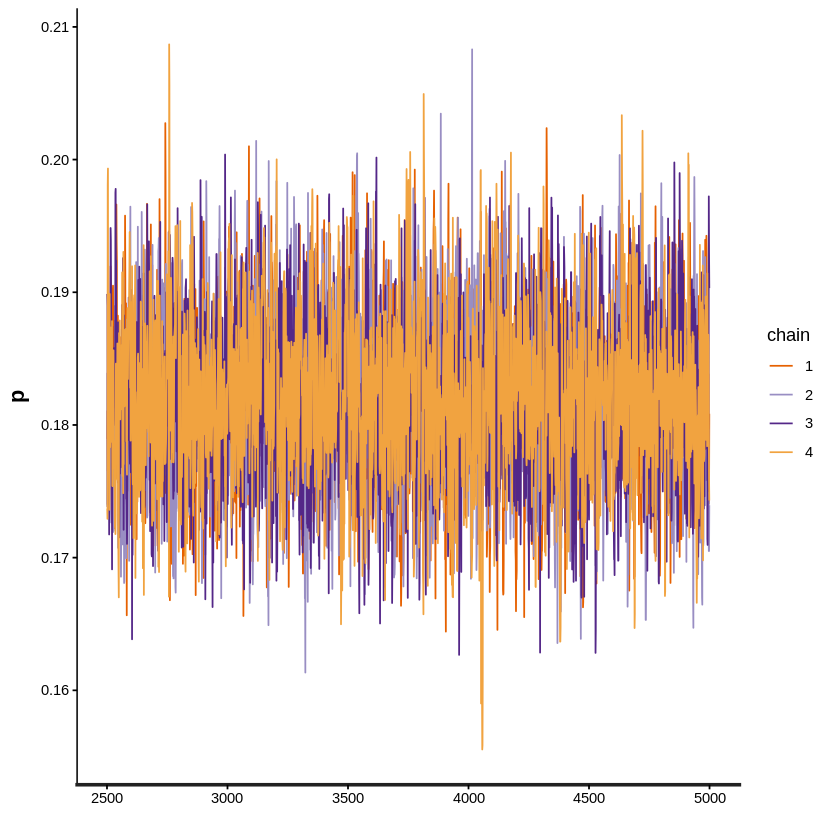

In [95]:
print(fit_mcmc, pars = c("p"), digits = 5)
stan_trace(fit_mcmc, pars = "p")

# looks like it did converge

# Exercise 3.2) Other posterior inference algorithms in Stan, e.g. variational inference algorithm

In addition to MCMC, I fit the same Beta–Binomial model using Stan’s variational inference. For this one-parameter conjugate model, MCMC is already fast and we have a closed-form Beta posterior, so VI is not necessary, but it provides an approximate posterior that is useful for comparison. The posterior mean and 95% credible interval for
𝑝 under VI were very similar to those from MCMC and from the analytic Beta posterior, although VI had a slightly lower posterior variance (.00618 SD VB vs .00639 SD Analytical vs 0.00625 MCMC).

Note that the Posterior predictive looks centered as well.
Code Below:


In [91]:
sm <- stan_model("reachMLB7.stan")

fit_vi <- vb(
  object = sm,
  data   = stan_data,  # same list as MCMC
  seed   = 321
)


Chain 1: ------------------------------------------------------------
Chain 1: EXPERIMENTAL ALGORITHM:
Chain 1:   This procedure has not been thoroughly tested and may be unstable
Chain 1:   or buggy. The interface is subject to change.
Chain 1: ------------------------------------------------------------
Chain 1: 
Chain 1: 
Chain 1: 
Chain 1: Gradient evaluation took 9e-06 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Begin eta adaptation.
Chain 1: Iteration:   1 / 250 [  0%]  (Adaptation)
Chain 1: Iteration:  50 / 250 [ 20%]  (Adaptation)
Chain 1: Iteration: 100 / 250 [ 40%]  (Adaptation)
Chain 1: Iteration: 150 / 250 [ 60%]  (Adaptation)
Chain 1: Iteration: 200 / 250 [ 80%]  (Adaptation)
Chain 1: Success! Found best value [eta = 1] earlier than expected.
Chain 1: 
Chain 1: Begin stochastic gradient ascent.
Chain 1:   iter             ELBO   delta_ELBO_mean 

In [92]:
vi_draws <- as.data.frame(fit_vi)$p

mean(vi_draws)
sd(vi_draws)
quantile(vi_draws, c(0.025, 0.5, 0.975))


[1] 0.1811957

[1] 0.006184235

2.5%       50%     97.5% 
0.1700926 0.1811015 0.1932672

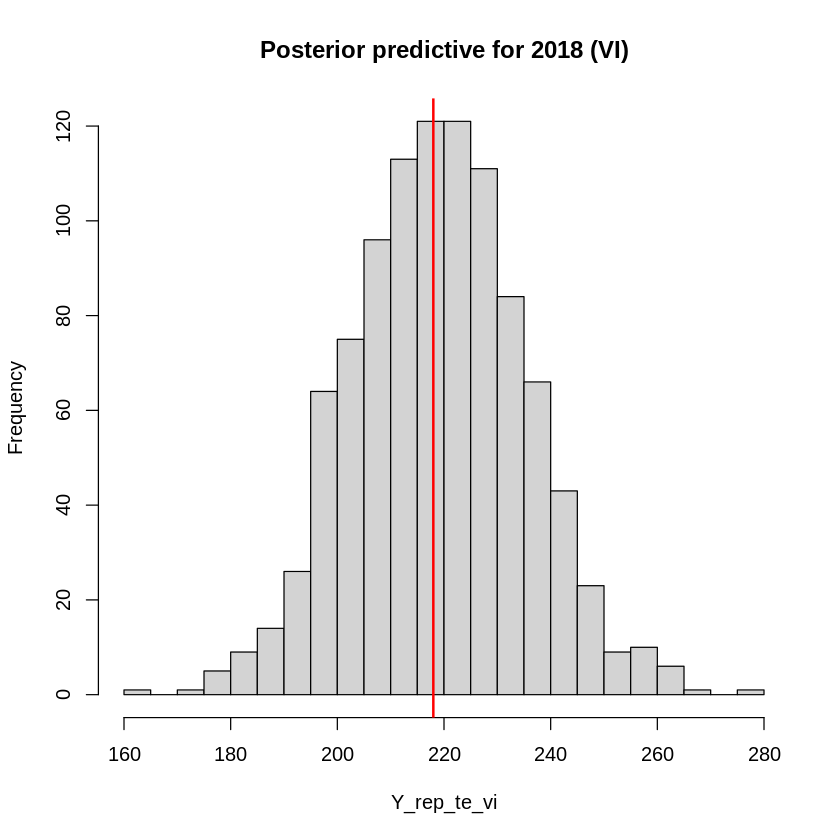

In [93]:
set.seed(321)
Y_rep_te_vi <- rbinom(length(vi_draws), size = n_test, prob = vi_draws)

hist(
  Y_rep_te_vi,
  breaks = 30,
  main = "Posterior predictive for 2018 (VI)",
  xlab  = "Y_rep_te_vi"
)
abline(v = Y_test, col = "red", lwd = 2)

# Posterior predictive looks centered as well:


# Exercise 3.3) obtain the maximum a posterior (MAP) estimate

I obtained a MAP estimate=.18161865, which just about matches the analytic Beta posterior mode and is very close to the posterior means from MCMC and VI. Note that this is only a point estimate and has no measure of uncertainty

p_map is very close to the mean from the analytic model

Code below:

In [96]:
# MAP / optimization
fit_map <- optimizing(
  object = sm,
  data   = stan_data,
  seed   = 321
)

# extract the MAP estimate for p
p_map <- fit_map$par["p"]
p_map

p 
0.1816189

In [97]:
p_map_analytic <- (a_post - 1) / (a_post + b_post - 2)

p_map_analytic
p_map


[1] 0.1816187

p 
0.1816189

# Exercise 3.4) Put all the checks we have done so far into one spot and visualize.
The three methods produce nearly identical posterior means and 95 % credible intervals. VI has somewhat smaller Posterior Standard Deviation.

Code below:

In [98]:
set.seed(321)
n_sims <- 4000

## Analytic Beta posterior
p_beta <- rbeta(n_sims, a_post, b_post)

## MCMC (from Stan)
p_mcmc <- rstan::extract(fit_mcmc, pars = "p")$p   # length ~ 10000

## VI (vb)
p_vi <- as.data.frame(fit_vi)$p


In [99]:
summaries <- rbind(
  data.frame(
    method = "Analytic Beta",
    mean   = mean(p_beta),
    sd     = sd(p_beta),
    q2.5   = quantile(p_beta, 0.025),
    q50    = quantile(p_beta, 0.5),
    q97.5  = quantile(p_beta, 0.975)
  ),
  data.frame(
    method = "MCMC",
    mean   = mean(p_mcmc),
    sd     = sd(p_mcmc),
    q2.5   = quantile(p_mcmc, 0.025),
    q50    = quantile(p_mcmc, 0.5),
    q97.5  = quantile(p_mcmc, 0.975)
  ),
  data.frame(
    method = "VI (vb)",
    mean   = mean(p_vi),
    sd     = sd(p_vi),
    q2.5   = quantile(p_vi, 0.025),
    q50    = quantile(p_vi, 0.5),
    q97.5  = quantile(p_vi, 0.975)
  )
)

print(summaries)


             method      mean          sd      q2.5       q50     q97.5
2.5%  Analytic Beta 0.1819319 0.006485975 0.1698838 0.1819059 0.1949752
2.5%1          MCMC 0.1819586 0.006245130 0.1699603 0.1819621 0.1942845
2.5%2       VI (vb) 0.1811957 0.006184235 0.1700926 0.1811015 0.1932672


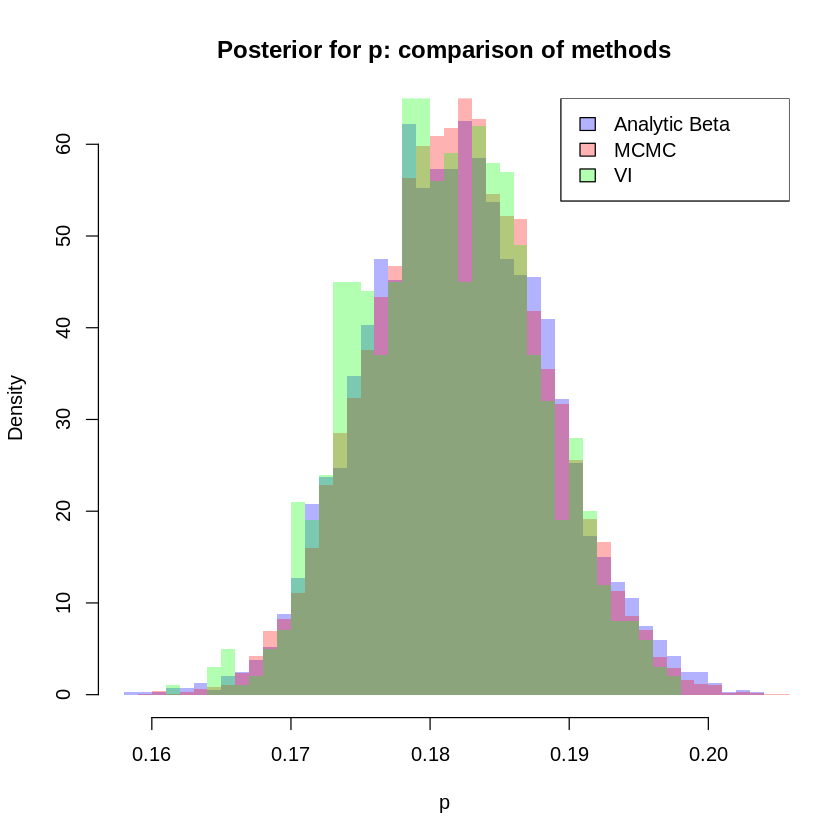

In [100]:
hist(p_beta,  breaks = 40, freq = FALSE,
     main = "Posterior for p: comparing methods",
     xlab = "p", border = NA, col = rgb(0, 0, 1, 0.3))
hist(p_mcmc, breaks = 40, freq = FALSE,
     border = NA, col = rgb(1, 0, 0, 0.3), add = TRUE)
hist(p_vi,   breaks = 40, freq = FALSE,
     border = NA, col = rgb(0, 1, 0, 0.3), add = TRUE)

legend("topright",
       legend = c("Analytic Beta", "MCMC", "VI"),
       fill   = c(rgb(0,0,1,0.3), rgb(1,0,0,0.3), rgb(0,1,0,0.3)))


# Exercise 3.5)
Compare the posterior predictive check results. I generated posterior predictive distiribtions using analytic posterior, MCMC, VI and a MAP estimate. Resulting histograms below are very close, centered around 220 oe 221. Tail probabilities that $P(\tilde{Y}_{2018} >= Y_{test})$ were were between .56 and .59, so the data seems to suggest that the actual 2018 draft results were typical.

Code below:

In [102]:
# MCMC
Y_rep_te_mcmc <- rbinom(length(p_mcmc), size = n_test, prob = p_mcmc)

# VI
Y_rep_te_vi <- rbinom(length(p_vi), size = n_test, prob = p_vi)

#MAP
Y_rep_te_vi <- rbinom(length(p_vi), size = n_test, prob = p_vi)


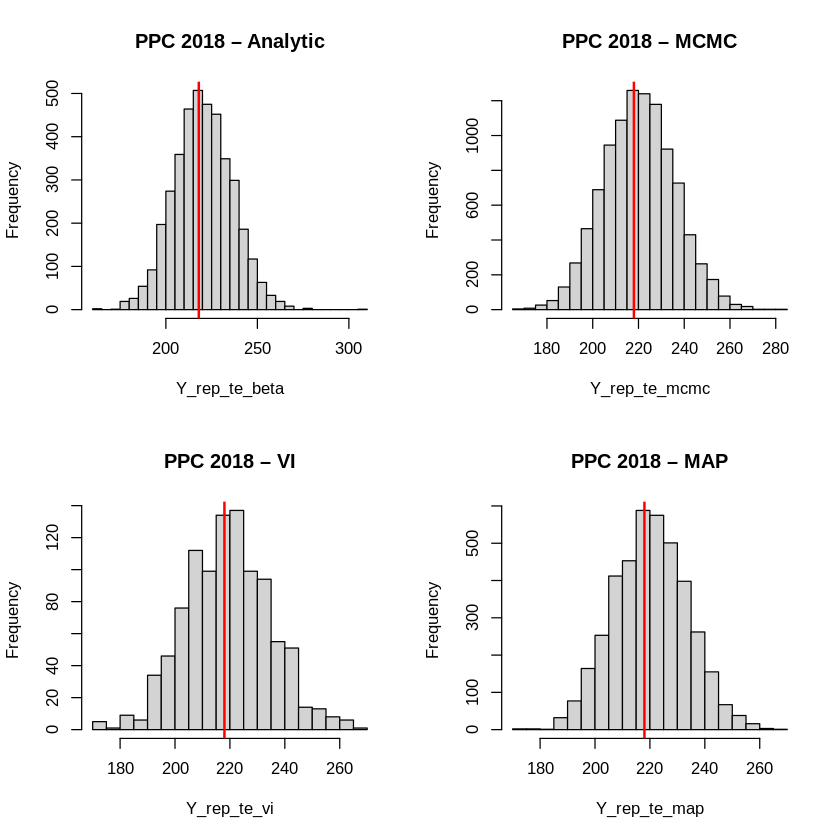

In [103]:
par(mfrow = c(2,2))

hist(Y_rep_te_beta, breaks = 30,
     main = "PPC 2018 – Analytic",
     xlab = "Y_rep_te_beta")
abline(v = Y_test, col = "red", lwd = 2)

hist(Y_rep_te_mcmc, breaks = 30,
     main = "PPC 2018 – MCMC",
     xlab = "Y_rep_te_mcmc")
abline(v = Y_test, col = "red", lwd = 2)

hist(Y_rep_te_vi, breaks = 30,
     main = "PPC 2018 – VI",
     xlab = "Y_rep_te_vi")
abline(v = Y_test, col = "red", lwd = 2)

hist(Y_rep_te_map, breaks = 30,
     main = "PPC 2018 – MAP",
     xlab = "Y_rep_te_map")
abline(v = Y_test, col = "red", lwd = 2)


In [104]:
ppc_summary <- data.frame(
  method = c("Analytic", "MCMC", "VI", "MAP"),
  mean   = c(mean(Y_rep_te_beta),
             mean(Y_rep_te_mcmc),
             mean(Y_rep_te_vi),
             mean(Y_rep_te_map)),
  sd     = c(sd(Y_rep_te_beta),
             sd(Y_rep_te_mcmc),
             sd(Y_rep_te_vi),
             sd(Y_rep_te_map)),
  p_gt   = c(mean(Y_rep_te_beta >= Y_test),
             mean(Y_rep_te_mcmc >= Y_test),
             mean(Y_rep_te_vi   >= Y_test),
             mean(Y_rep_te_map  >= Y_test))
)

ppc_summary


method,mean,sd,p_gt
<chr>,<dbl>,<dbl>,<dbl>
Analytic,220.9280,15.83117,0.58175
MCMC,220.8082,15.47818,0.58330
VI,219.7390,15.43318,0.55800
MAP,220.6533,13.45073,0.58925


# Exercise 3.6) Compare run times.
Comparing the analytic Beta seems unnecessary, but we can see that MCMC took 4 times as long as VI, and MAP was much quicker than even VI:
\begin{aligned}
MCMC: elapsed: 0.227999999999156
\\
VI: elapsed: 0.0500000000029104
\\
MAP: elapsed: 0.00900000000183354
\end{aligned}

Code below:

In [105]:
# 1. MCMC
time_mcmc <- system.time({
  fit_mcmc <- sampling(   # or stan(...)
    object = sm,
    data   = stan_data,
    iter   = 2000,
    chains = 4,
    seed   = 321
  )
})

time_mcmc



SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 6.6e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.018 seconds (Warm-up)
Chain 1:                0.015 seconds (Sampling)
Chain 1:                0.03

   user  system elapsed 
  0.215   0.005   0.228 

In [106]:
# 2. Variational inference (VI / vb)
time_vi <- system.time({
  fit_vi <- vb(
    object = sm,
    data   = stan_data,
    seed   = 321
  )
})

time_vi


Chain 1: ------------------------------------------------------------
Chain 1: EXPERIMENTAL ALGORITHM:
Chain 1:   This procedure has not been thoroughly tested and may be unstable
Chain 1:   or buggy. The interface is subject to change.
Chain 1: ------------------------------------------------------------
Chain 1: 
Chain 1: 
Chain 1: 
Chain 1: Gradient evaluation took 6e-06 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Begin eta adaptation.
Chain 1: Iteration:   1 / 250 [  0%]  (Adaptation)
Chain 1: Iteration:  50 / 250 [ 20%]  (Adaptation)
Chain 1: Iteration: 100 / 250 [ 40%]  (Adaptation)
Chain 1: Iteration: 150 / 250 [ 60%]  (Adaptation)
Chain 1: Iteration: 200 / 250 [ 80%]  (Adaptation)
Chain 1: Success! Found best value [eta = 1] earlier than expected.
Chain 1: 
Chain 1: Begin stochastic gradient ascent.
Chain 1:   iter             ELBO   delta_ELBO_mean 

   user  system elapsed 
  0.047   0.002   0.050 

In [107]:
# 3. MAP / optimization
time_map <- system.time({
  fit_map <- optimizing(
    object = sm,
    data   = stan_data,
    seed   = 321
  )
})

time_map


   user  system elapsed 
  0.009   0.000   0.009 

In [110]:
time_mcmc["elapsed"]
time_vi["elapsed"]
time_map["elapsed"]


elapsed 
  0.228

elapsed 
   0.05

elapsed 
  0.009

# Exercise 3.7)
Compare Posterior Samples mean and mode. Based on the below,

### Comparison of Posterior Summaries and MAP

The MAP estimate from Stan’s `optimizing()` function was = 0.1816, which matches the analytic Beta
posterior mode and is about identical to the posterior means from the
analytic, MCMC, and VI methods (all around 0.182). The differences
between methods are an order of magnitude smaller than the posterior
standard deviation (approximately 0.006 for each method), so in this simple
one-parameter, unimodal Beta–Binomial model, the MAP and the full
posterior summaries are effectively the same. Code below:


In [111]:
# Analytic mean
beta_mean <- a_post / (a_post + b_post)

# Analytic mode (Beta mode = (a-1)/(a+b-2) when a,b > 1)
beta_mode <- (a_post - 1) / (a_post + b_post - 2)

mcmc_mean <- mean(p_mcmc)

# approximate mode using density()
dens_mcmc <- density(p_mcmc)
mcmc_mode <- dens_mcmc$x[which.max(dens_mcmc$y)]

# VI
vi_mean <- mean(p_vi)

dens_vi <- density(p_vi)
vi_mode <- dens_vi$x[which.max(dens_vi$y)]

compare_pm <- data.frame(
  method = c("Analytic Beta", "MCMC", "VI (vb)", "MAP"),
  mean   = c(beta_mean,       mcmc_mean, vi_mean,  p_map),
  mode   = c(beta_mode,       mcmc_mode, vi_mode,  p_map)  # MAP is itself a mode
)

compare_pm




method,mean,mode
<chr>,<dbl>,<dbl>
Analytic Beta,0.1817933,0.1816187
MCMC,0.1819586,0.1823980
VI (vb),0.1811957,0.1797526
MAP,0.1816189,0.1816189
